In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling, RandomContrast
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
import tensorflow_probability as tfp

from tensorflow.keras.regularizers import L2,L1

from tensorboard.plugins.hparams import api as hp

import albumentations as A

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

import datetime


import wandb
from wandb.keras import WandbCallback

import io


### wandb Login and initialization, configuration

In [6]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [7]:
# wandb.init(project = "Malaria-Detection", entity ="ihsaansiddiqui")

# wandb.tensorboard.patch(root_logdir = "./logs")
wandb.init(project = "Malaria-Detection", entity ="ihsaansiddiqui",  sync_tensorboard = True)

In [8]:
wandb.config={
      "LEARNING_RATE": 0.001,
      "N_EPOCHS": 5,
      "BATCH_SIZE": 128,
      "DROPOUT_RATE": 0.0,
      "IM_SIZE": 224,
      "REGULARIZATION_RATE": 0.0,
      "N_FILTERS": 6,
      "KERNEL_SIZE": 3,
      "N_STRIDES": 1,
      "POOL_SIZE": 2,
      "N_DENSE_1": 128,
      "N_DENSE_2": 32,
        
      }

### Data Preparation

In [9]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split = ['train'])

In [10]:
def split(dataset, TRAIN_RATIO = 0.8, VAL_RATIO=0.1, TEST_RATIO=0.1):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    
    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
    
    test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
    
    return train_dataset, val_dataset, test_dataset

In [19]:
train_dataset, val_dataset, test_dataset = split(dataset[0])
print(list(train_dataset.take(1).as_numpy_iterator())
      , list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

### Visualization 

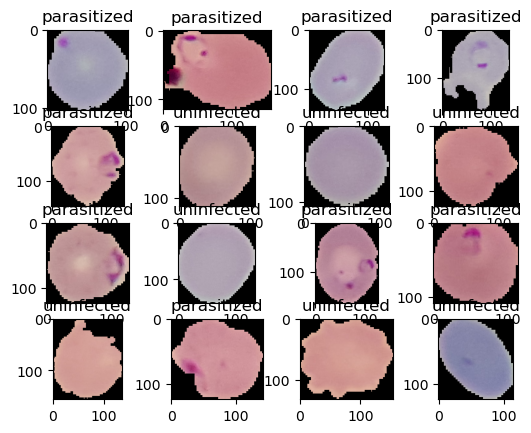

In [20]:
for i, (image,label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))

### Data Processing

#### Data Augmentation

In [21]:
def visualize (original, augmented):
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(original))
    
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(augmented))

In [22]:
original_image, label = next(iter(train_dataset))

In [23]:
augmented_image = tf.image.flip_left_right(original_image)

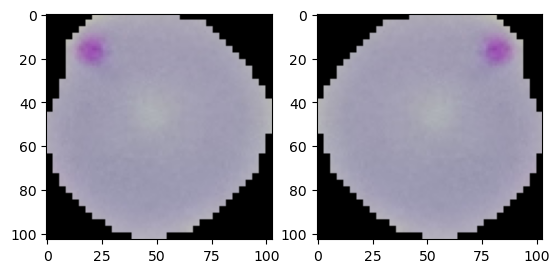

In [24]:
visualize(original_image, augmented_image)

In [25]:
IM_SIZE = 224
@tf.function
def resize_rescale(image,label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/ 255.0 , label

In [26]:
#tf.kears.layer.resizing and scaling
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0/255.0),
])

In [27]:
### tf.image augmentation
def augment(image, label):
    
    image, label = resize_rescale(image,label)
    
    image = tf.image.rot90(image, k = tf.random.uniform(shape=[], minval = 0, maxval=2, dtype=tf.int32))
#     image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
#     image = tf.image.stateless_random_saturation(image, 0.3,0.5)
    image = tf.image.stateless_random_flip_left_right(image)
    
    return image, label

In [518]:
class RotNinety(Layer):
    def __init__(self):
        super().__init__()
    
    def call(self, image):
        return tf.image.rot90(image,  k = tf.random.uniform(shape=[], minval = 0, maxval=2, dtype=tf.int32))

#### Augmentation layer

In [28]:
### tf.keras.layer augment

augment_layers = tf.keras.Sequential([
    RandomRotation(factor =(0.25,0.2501), ),
#     RotNinety(),
    RandomFlip(mode = 'horizontal',),
    RandomContrast(factor = 0.1),
])

def augment_layer(image,label):
#     image, label = resize_rescale(image,label)
    return augment_layers(resize_rescale_layers(image),training = True), label

In [29]:
# train_dataset = train_dataset.map(resize_rescale)
# val_dataset = val_dataset.map(resize_rescale)
# test_dataset = test_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)

In [30]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [522]:
for image, label in train_dataset.take(1):
    print(image,label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(103, 103, 3), dtype=uint8) tf.Tensor(0, shape=(), dtype=int64)


In [31]:
BATCH_SIZE = 32
train_dataset = (
    train_dataset.shuffle(buffer_size = 1024, reshuffle_each_iteration  = True)
    .map(augment_layer)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
# val_dataset = (
# #     val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration  = True)
# #     .map(augment_layer)
#     val_dataset
#     .map(resize_rescale)
#     .batch(BATCH_SIZE)
#     .prefetch(tf.data.AUTOTUNE)
# )

In [32]:
val_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

#### Mixup Data Augmentation

In [413]:
train_dataset_1 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale)
train_dataset_2 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [414]:
def mixup(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2,label_2) = train_dataset_1, train_dataset_2

    lamda = tfp.distributions.Beta(0.2,0.2)
    lamda = lamda.sample(1)[0]

    image = lamda * image_1 + (1 - lamda)* image_2
    label = lamda * tf.cast(label_1, dtype = tf.float32) + (1 - lamda)* tf.cast(label_2, dtype = tf.float32)
    
    return image, label

In [171]:
# BATCH_SIZE = 32
# train_dataset = (
#     mixed_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration  = True)
# #     .map(mixup)
#     .map(cutmix)
#     .batch(BATCH_SIZE)
#     .prefetch(tf.data.AUTOTUNE)
# )

In [33]:
val_dataset = (
     val_dataset
    .map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(128)
)

#### CutMix Augmentation

In [77]:
def box(lamda):
    
    r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
    
    r_w = tf.cast(IM_SIZE * tf.math.sqrt(1-lamda), dtype = tf.int32)
    r_h = tf.cast(IM_SIZE * tf.math.sqrt(1-lamda), dtype = tf.int32)    
    
    r_x = tf.clip_by_value(r_x +r_w//2, 0, IM_SIZE)
    r_y = tf.clip_by_value(r_y +r_h//2, 0, IM_SIZE)  
    
    x_b_r = tf.clip_by_value(r_x +r_w//2, 0, IM_SIZE)
    y_b_r = tf.clip_by_value(r_y +r_h//2, 0, IM_SIZE)    
    
    
    r_w = x_b_r - r_x
    
    if(r_w == 0):
        r_w = 1
        
    r_h = y_b_r - r_y
    if(r_h == 0):
        r_h = 1
        
    return r_y, r_x,r_h,r_w

In [78]:
def cutmix(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2,label_2) = train_dataset_1, train_dataset_2
    
    lamda = tfp.distributions.Beta(0.2,0.2)
    lamda = lamda.sample(1)[0]
    
    r_y, r_x, r_h,r_w = box(lamda)
    
    crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h,r_w)
    pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

    crop_1= tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h,r_w)
    pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)
    
    image = image_1 - pad_1 + pad_2
    
    lamda = tf.cast(1 - (r_w * r_h) / (IM_SIZE * IM_SIZE), dtype = tf.float32)
    label = lamda * tf.cast(label_1, dtype = tf.float32) + (1 - lamda)* tf.cast(label_2, dtype = tf.float32)
    
    

    return image, label


In [ ]:
original_image, label = next(iter(train_dataset))
print(label)

plt.imshow(original_image[0])

#### Albumentations

In [113]:
transforms = A.Compose([
    A.Resize(IM_SIZE,IM_SIZE),
    A.OneOf([A.HorizontalFlip(),
    A.VerticalFlip(),], p = 0.3),
    
    
    A.RandomRotate90(),
#     A.RandomGridShuffle(grid =(3,3), always_apply= False, p=0.5),
    A.RandomBrightnessContrast(brightness_limit = 0.2, contrast_limit = 0.2, brightness_by_max = True, always_apply = False, p = 0.5),
#     A.Sharpen(alpha = (0.2, 0.5), lightness = (0.5,1.0), always_apply = False, p = 0.5),
    A.Cutout(),
])

In [114]:
def aug_albument(image):
    data = {"image" : image}
    image = transforms(**data)
    image = image["image"]
    image = tf.cast(image/255.0, tf.float32)
    
    return image

In [115]:
def process_data(image, label):
    aug_img = tf.numpy_function(func = aug_albument, inp = [image], Tout= tf.float32)
    return aug_img, label

In [11]:
train_dataset = (
    train_dataset.shuffle(buffer_size = 1024, reshuffle_each_iteration  = True)
    .map(process_data)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


In [117]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

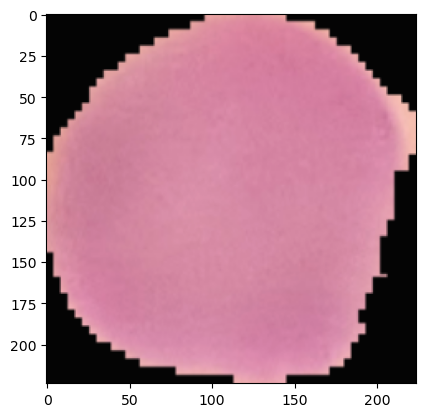

In [118]:
im, label = next(iter(train_dataset))
plt.imshow(im[0])

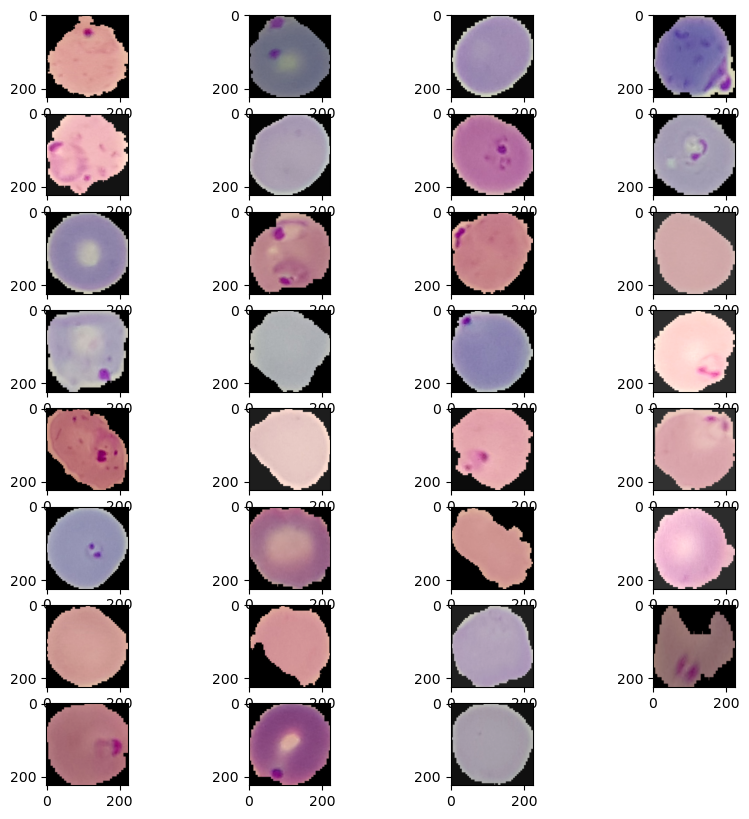

In [119]:
plt.figure(figsize = (10,10))

for i in range(1,32):
    plt.subplot(8,4,i)
    plt.imshow(im[i])

### Model Creation

### Sequential API

In [34]:
CONFIGURATION = wandb.config

IM_SIZE = CONFIGURATION['IM_SIZE']
# dropout_rate = 0.2
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
# regularization_rate = 0.01
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
KERNAL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']
N_FILTERS = CONFIGURATION['N_FILTERS']


lenet_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
                             
#                              resize_rescale_layers,
#                              augment_layers,
    
                             Conv2D(filters = N_FILTERS, kernel_size = KERNAL_SIZE, strides = N_STRIDES, padding = 'valid', activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
                             BatchNormalization(),
                             MaxPool2D(pool_size = POOL_SIZE, strides = N_STRIDES * 2),
                             Dropout(rate = DROPOUT_RATE),
    
                             Conv2D(filters = N_FILTERS * 2 + 4, kernel_size = KERNAL_SIZE, strides = N_STRIDES, padding = 'valid', activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
                             BatchNormalization(),                        
                             MaxPool2D(pool_size = POOL_SIZE, strides = N_STRIDES * 2),
    
                             Flatten(),
    
                             Dense(CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
                             BatchNormalization(),
                             Dropout(rate = DROPOUT_RATE),
    
                             Dense(CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
                             BatchNormalization(),
    
                             Dense(1, activation = "sigmoid"),   

])

lenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)     

### Functional API

In [14]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters =6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)

x = Conv2D(filters =16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output =  MaxPool2D(pool_size = 2, strides = 2)(x)

feature_extractor_model = Model(func_input, output, name = "feature_extractor")
feature_extractor_model.summary()
                                        
                            

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)

In [15]:
IM_SIZE - 224
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    
    
    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),                        
    MaxPool2D(pool_size = 2, strides = 2),
    
    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
])

feature_extractor_seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_7 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [16]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")
# x = feature_extractor_model(func_input)
x  = feature_extractor_seq_model(func_input)
x =  Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

output =  Dense(1, activation = "sigmoid")(x)

lenet_model = Model(func_input, output, name = "lenet_model")

lenet_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_8 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                       

## Model Subclassing

In [17]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(FeatureExtractor, self).__init__()
        
        self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D (pool_size = pool_size, strides = 2 * strides)
        
        self.conv_2 = Conv2D(filters = filters * 2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D (pool_size = pool_size, strides = 2 * strides)
        
    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)
        
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)
        
        return x
    
feature_sub_classed = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)

In [18]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")
# x = feature_extractor_model(func_input)
x  = feature_sub_classed(func_input)
x =  Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

output =  Dense(1, activation = "sigmoid")(x)

lenet_model = Model(func_input, output, name = "lenet_model")

lenet_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_12 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

## Model Class

In [19]:
class LenetModel(Model):
    def __init__(self):
        super(LenetModel, self).__init__()
        
        self.feature_extractor = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)
        
        self.flatten = Flatten()
        
        self.dense_1 = Dense(100, activation = "relu")
        self.batch_1 = BatchNormalization()
        
        self.dense_2 = Dense(1, activation = "sigmoid")
        self.batch_2 = BatchNormalization()
        
        self.dense_3 = Dense(1, activation = "sigmoid")
        
    def call(self, x, training):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.dense_2(x)
        x = self.batch_2(x)
        x = self.dense_3(x)

        
        return x
    
lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))

lenet_sub_classed.summary()




Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_16 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            multiple                  101       
                                                                 
 batch_normalization_17 (Ba  multiple                  

## Custom dense layer

In [20]:
class CustomDenseLayer(Layer):
    def __init__(self, output_units, activation):
        super(CustomDenseLayer, self).__init__()
        self.output_units = output_units
        self.activation = activation
        
    def build(self, input_feature_shape):
        self.w = self.add_weight(shape = (input_feature_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
        self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal", trainable = True)
        
    def call(self, input_features):
            
        pre_output = tf.matmul(input_features, self.w) + self.b
            
            
        if self.activation == "relu":
            return tf.nn.relu(pre_output)
            
        elif self.activation == "sigmoid":
            return tf.math.sigmoid(pre_output)
            
        else:
            return pre_output

In [21]:
IM_SIZE = 224
lenet_custom_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    
                             Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D(pool_size = 2, strides = 2),
    
                             Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
                             BatchNormalization(),                        
                             MaxPool2D(pool_size = 2, strides = 2),
    
                             Flatten(),
    
                             CustomDenseLayer(10, activation = "relu"),
                             BatchNormalization(),
    
                             CustomDenseLayer(10, activation = "relu"),
                             BatchNormalization(),
    
                             CustomDenseLayer(1, activation = "sigmoid"),   

])

lenet_custom_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_18 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_19 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

### Callbacks

In [22]:
class LossCallback(Callback):
    def on_epoch_end(self,epoch, logs):
        print("\n For Epoch Number {} the model has a loss of {}".format(epoch+1, logs["loss"]))
        
    def on_batch_end(self, batch, logs):
        print("\n For Batch Number {} the model has a loss of {}".format(batch + 1, logs))

In [603]:
test_dataset = test_dataset.batch(1)

In [313]:
class LogImagesCallbackTensorboard(Callback):
    def on_epoch_end(self,epoch, logs):
        labels = []
        inp = []

        for x,y in test_dataset.as_numpy_iterator():
            labels.append(y)
            inp.append(x)
        labels = np.array([i[0] for i in labels])
        predicted = lenet_model.predict(np.array(inp)[:,0,...])
        threshold = 0.5

        cm = confusion_matrix(labels, predicted > threshold)

        plt.figure(figsize = (8,8))

        sns.heatmap(cm, annot = True,)

        plt.title('confusion matrix - {}'.format(threshold))

        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.axis('off')
        
        buffer = io.BytesIO()
        plt.savefig(buffer, format = 'png')
        
        image = tf.image.decode_png(buffer.getvalue(), channels = 3)
        image = tf.expand_dims(image, axis = 0)
        
        CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
        IMAGE_DIR = './logs/' + CURRENT_TIME + '/images'
        image_writer = tf.summary.create_file_writer(IMAGE_DIR)
        
        with image_writer.as_default():
            tf.summary.image("Training data", image, step = epoch)
        
        

In [619]:
class LogImagesCallbackWanDBPlot(Callback):
    def on_epoch_end(self,epoch, logs):
        labels = []
        inp = []
        pred = []

        for x,y in test_dataset.as_numpy_iterator():
            labels.append(y)
            inp.append(x)
        labels = np.array([i[0] for i in labels])
        predicted = lenet_model.predict(np.array(inp)[:,0,...])    

        for i in range(len(predicted)):
            if (predicted[i][0] < 0.5):
               pred.append([1,0])
            else:
                pred.append([0,1])
        pred = np.array(pred)

#         wandb.log({"confusion Matrix" : wandb.plot.confusion_matrix
#                    (probs = pred,
#                     y_true = labels,
#                     class_names= ["Parasitized", "Uninfected"])})
        wandb.log({"ROC Curve" : wandb.plot.roc_curve(
                 y_true = labels,
                 y_probas = pred,
                 labels = ["Parasitized", "Uninfected"],
                 )})
        wandb.log({'loss': logs['loss']})

In [624]:
class LogImagesCallbackWanDB(Callback):
    def on_epoch_end(self,epoch, logs):
        labels = []
        inp = []

        for x,y in test_dataset.as_numpy_iterator():
            labels.append(y)
            inp.append(x)
        labels = np.array([i[0] for i in labels])
        predicted = lenet_model.predict(np.array(inp)[:,0,...])
        threshold = 0.5

        cm = confusion_matrix(labels, predicted > threshold)

        plt.figure(figsize = (8,8))

        sns.heatmap(cm, annot = True,)

        plt.title('confusion matrix - {}'.format(threshold))

        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.axis('off')
        
        buffer = io.BytesIO()
        plt.savefig(buffer, format = 'png')
        
        image_array = tf.image.decode_png(buffer.getvalue(), channels = 3)
        
        images = wandb.Image(image_array, caption = 'Confusion Matrix for epoch: {}'.format(epoch))
        
        wandb.log({"Confusion Matrix":images})
     

In [23]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)

In [24]:
es_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [266]:
def scheduler(epoch, lr):
    
  if epoch < 2:
    learning_rate =  lr
  else:
    learning_rate = lr * tf.math.exp(-0.1)
  with train_writer.as_default():
        tf.summary.scalar('Learning Rate', data = learning_rate, step = epoch)
  return learning_rate

scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

In [500]:
# check_point = ModelCheckpoint(
#     'checkpoints/',
#     monitor = 'val_loss',
#     verbose = 0,
#     save_best_only = True,
#     save_weights_only = False,
#     mode = 'auto',
#     save_freq='epoch',
# )

checkpoint_callback = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor = 'val_precision', verbose = 0, save_best_only = True,
    save_weight_only = True, mode = 'auto', save_freq = 'epoch',
)

In [83]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
)

### Tensorboard

In [349]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
METRIC_DIR = './logs/' + CURRENT_TIME + '/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [352]:
LOG_DIR = "./logs" + CURRENT_TIME
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = LOG_DIR, histogram_freq = 1, profile_batch = '100,132')


2024-03-01 15:48:32.727902: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-03-01 15:48:32.727933: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-03-01 15:48:32.729249: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


### Custom Loss and Metrics

In [221]:
def custom_bce(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)

In [222]:
def custom_bce_loss(Factor):
    def loss(y_true, y_pred):
        bce = BinaryCrossentropy()
    
        return bce(y_true, y_pred) * Factor
    return loss 

#### Custom Loss Class

In [124]:
FACTOR = 1
class CustomBCE(tf.keras.losses.Loss):
    def __init__(self, FACTOR):
        super(CustomBCE, self).__init__()
        self.FACTOR = FACTOR
        
    def call(self, y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred) * self.FACTOR
    
    

#### Custom metric

In [125]:
def custom_accuracy(y_true, y_pred):
    return binary_accuracy(y_true, y_pred)

In [126]:
def custom_accuracy(Factor):
    def metric(y_true, y_pred):
         return binary_accuracy(y_true, y_pred) * Factor
    return metric

In [273]:
FACTOR = 1
class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name = 'Custom_Accuracy',FACTOR = 1):
        super(CustomBCE, self).__init__()
        self.FACTOR = FACTOR
        self.accuracy = self.add_weight(name - name , initializer = 'zeros')
        
    def update_state(self, y_true, y_pred, sample_weight = None):
        output = binary_accuracy(tf.cast(y_true, dtype = tf.float32), y_pred) * self.FACTOR
        
        self.accuracy.assign(tf.math.count_nonzero(output, dtype = tf.float32)/ tf.cast(len(output), dtype = tf.float32))
        
    def result(self):
        return self.accuracy
    def reset_states(self):
        self.accuracy.assign(0.)
    

### Hyperparameter Tuning

In [343]:
IM_SIZE = 224
def model_tune(hparams):
#     print("The hparam array is:{}".format(hparams))
    lenet_model = tf.keras.Sequential([
                                 InputLayer(input_shape = (None, None, 3)),

                                 resize_rescale_layers,
                                 augment_layers,

                                 Conv2D(filters =6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
                                 BatchNormalization(),
                                 MaxPool2D(pool_size = 2, strides = 2),
                                 Dropout(rate = hparams[HP_DROPOUT]),

                                 Conv2D(filters =16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
                                 BatchNormalization(),                        
                                 MaxPool2D(pool_size = 2, strides = 2),

                                 Flatten(),

                                 Dense(hparams[HP_NUM_UNITS_1], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
                                 BatchNormalization(),
                                 Dropout(rate = hparams[HP_DROPOUT]),

                                 Dense(hparams[HP_NUM_UNITS_2], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
                                 BatchNormalization(),

                                 Dense(1, activation = "sigmoid"),   

    ])


    lenet_model.compile(optimizer = Adam(lr = hparams[HP_LEARNING_RATE]),
                 loss = 'binary_crossentropy',
    #              loss = CustomBCE(FACTOR),
                 metrics = ['accuracy'],)

    lenet_model.fit(val_dataset,  epochs = 1)
    _, accuracy = lenet_model.evaluate(val_dataset)

    return accuracy

In [344]:
HP_NUM_UNITS_1 = hp.HParam('num_unites_1', hp.Discrete([16,32,64,128]))
HP_NUM_UNITS_2 = hp.HParam('num_unites_2', hp.Discrete([16,32,64,128]))
HP_DROPOUT = hp.HParam('dropout_rate', hp.Discrete([0.1, 0.2, 0.3]))
HP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.001, 0.01, 0.1]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3]))

In [348]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
    for num_units_2 in HP_NUM_UNITS_2.domain.values:
        for dropout_rate in HP_DROPOUT.domain.values:
            for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
                for learning_rate in HP_LEARNING_RATE.domain.values:
                    
                    hparams = {
                        HP_NUM_UNITS_1 : num_units_1,
                        HP_NUM_UNITS_2 : num_units_2,
                        HP_DROPOUT : dropout_rate,
                        HP_REGULARIZATION_RATE:regularization_rate,
                        HP_LEARNING_RATE: learning_rate
                    }
                    
                    file_writer = tf.summary.create_file_writer('logs/hparams' + str(run_number))
                    
                    with file_writer.as_default():
                        hp.hparams(hparams)
                        accuracy = model_tune(hparams)
                        tf.summary.scalar('accuracy', accuracy, step = 0)
                        
                    print("For the run {} :hparams num_units_1:{}, num_units_2:{}, dropout:{}, regularization_rate:{}, learning_rate:{}".format(
                          run_number, hparams[HP_NUM_UNITS_1], hparams[HP_NUM_UNITS_2], hparams[HP_DROPOUT], hparams[HP_REGULARIZATION_RATE], hparams[HP_LEARNING_RATE]))
                        
                    run_number +=1
    

87/87 [==============================] - 4s 31ms/step - loss: 0.7540 - accuracy: 0.5053
For the run 0 :hparams num_units_1:16, num_units_2:16, dropout:0.1, regularization_rate:0.001, learning_rate:0.0001


87/87 [==============================] - 4s 33ms/step - loss: 0.7425 - accuracy: 0.5071
For the run 1 :hparams num_units_1:16, num_units_2:16, dropout:0.1, regularization_rate:0.001, learning_rate:0.001


87/87 [==============================] - 4s 33ms/step - loss: 1.0100 - accuracy: 0.4962
For the run 2 :hparams num_units_1:16, num_units_2:16, dropout:0.1, regularization_rate:0.01, learning_rate:0.0001


87/87 [==============================] - 4s 34ms/step - loss: 1.0835 - accuracy: 0.5038
For the run 3 :hparams num_units_1:16, num_units_2:16, dropout:0.1, regularization_rate:0.01, learning_rate:0.001


87/87 [==============================] - 4s 32ms/step - loss: 3.0178 - accuracy: 0.5049
For the run 4 :hparams num_units_1:16, num_units_2:16, dropout:0.1, regularization_rate:0.1, learning_rate:0.0001


87/87 [==============================] - 4s 32ms/step - loss: 3.1692 - accuracy: 0.5053
For the run 5 :hparams num_units_1:16, num_units_2:16, dropout:0.1, regularization_rate:0.1, learning_rate:0.001


87/87 [==============================] - 4s 32ms/step - loss: 0.7540 - accuracy: 0.5038
For the run 6 :hparams num_units_1:16, num_units_2:16, dropout:0.2, regularization_rate:0.001, learning_rate:0.0001


87/87 [==============================] - 4s 33ms/step - loss: 0.7536 - accuracy: 0.4973
For the run 7 :hparams num_units_1:16, num_units_2:16, dropout:0.2, regularization_rate:0.001, learning_rate:0.001


87/87 [==============================] - 4s 32ms/step - loss: 1.1545 - accuracy: 0.4933
For the run 8 :hparams num_units_1:16, num_units_2:16, dropout:0.2, regularization_rate:0.01, learning_rate:0.0001


87/87 [==============================] - 4s 32ms/step - loss: 1.0817 - accuracy: 0.5038
For the run 9 :hparams num_units_1:16, num_units_2:16, dropout:0.2, regularization_rate:0.01, learning_rate:0.001


87/87 [==============================] - 4s 33ms/step - loss: 3.7109 - accuracy: 0.4951
For the run 10 :hparams num_units_1:16, num_units_2:16, dropout:0.2, regularization_rate:0.1, learning_rate:0.0001


87/87 [==============================] - 4s 32ms/step - loss: 3.4519 - accuracy: 0.5071
For the run 11 :hparams num_units_1:16, num_units_2:16, dropout:0.2, regularization_rate:0.1, learning_rate:0.001


87/87 [==============================] - 4s 32ms/step - loss: 0.7514 - accuracy: 0.5064
For the run 12 :hparams num_units_1:16, num_units_2:16, dropout:0.3, regularization_rate:0.001, learning_rate:0.0001


87/87 [==============================] - 4s 33ms/step - loss: 0.7562 - accuracy: 0.5049
For the run 13 :hparams num_units_1:16, num_units_2:16, dropout:0.3, regularization_rate:0.001, learning_rate:0.001


87/87 [==============================] - 4s 32ms/step - loss: 1.1426 - accuracy: 0.5067
For the run 14 :hparams num_units_1:16, num_units_2:16, dropout:0.3, regularization_rate:0.01, learning_rate:0.0001


87/87 [==============================] - 4s 33ms/step - loss: 1.1126 - accuracy: 0.5042
For the run 15 :hparams num_units_1:16, num_units_2:16, dropout:0.3, regularization_rate:0.01, learning_rate:0.001


87/87 [==============================] - 4s 32ms/step - loss: 3.3012 - accuracy: 0.4951
For the run 16 :hparams num_units_1:16, num_units_2:16, dropout:0.3, regularization_rate:0.1, learning_rate:0.0001


87/87 [==============================] - 4s 32ms/step - loss: 3.2240 - accuracy: 0.4958
For the run 17 :hparams num_units_1:16, num_units_2:16, dropout:0.3, regularization_rate:0.1, learning_rate:0.001


87/87 [==============================] - 4s 32ms/step - loss: 0.7877 - accuracy: 0.5038
For the run 18 :hparams num_units_1:16, num_units_2:32, dropout:0.1, regularization_rate:0.001, learning_rate:0.0001


87/87 [==============================] - 4s 33ms/step - loss: 0.7597 - accuracy: 0.5034
For the run 19 :hparams num_units_1:16, num_units_2:32, dropout:0.1, regularization_rate:0.001, learning_rate:0.001


87/87 [==============================] - 4s 31ms/step - loss: 1.0716 - accuracy: 0.5067
For the run 20 :hparams num_units_1:16, num_units_2:32, dropout:0.1, regularization_rate:0.01, learning_rate:0.0001


87/87 [==============================] - 4s 32ms/step - loss: 1.1425 - accuracy: 0.5053
For the run 21 :hparams num_units_1:16, num_units_2:32, dropout:0.1, regularization_rate:0.01, learning_rate:0.001


87/87 [==============================] - 4s 31ms/step - loss: 3.6103 - accuracy: 0.5038
For the run 22 :hparams num_units_1:16, num_units_2:32, dropout:0.1, regularization_rate:0.1, learning_rate:0.0001


87/87 [==============================] - 4s 33ms/step - loss: 3.3630 - accuracy: 0.4973
For the run 23 :hparams num_units_1:16, num_units_2:32, dropout:0.1, regularization_rate:0.1, learning_rate:0.001


87/87 [==============================] - 4s 32ms/step - loss: 0.7532 - accuracy: 0.5045
For the run 24 :hparams num_units_1:16, num_units_2:32, dropout:0.2, regularization_rate:0.001, learning_rate:0.0001


87/87 [==============================] - 4s 34ms/step - loss: 0.7524 - accuracy: 0.5064
For the run 25 :hparams num_units_1:16, num_units_2:32, dropout:0.2, regularization_rate:0.001, learning_rate:0.001


87/87 [==============================] - 4s 31ms/step - loss: 1.1491 - accuracy: 0.5049
For the run 26 :hparams num_units_1:16, num_units_2:32, dropout:0.2, regularization_rate:0.01, learning_rate:0.0001


87/87 [==============================] - 4s 32ms/step - loss: 1.1464 - accuracy: 0.5071
For the run 27 :hparams num_units_1:16, num_units_2:32, dropout:0.2, regularization_rate:0.01, learning_rate:0.001


87/87 [==============================] - 4s 31ms/step - loss: 3.3812 - accuracy: 0.4947
For the run 28 :hparams num_units_1:16, num_units_2:32, dropout:0.2, regularization_rate:0.1, learning_rate:0.0001


87/87 [==============================] - 4s 32ms/step - loss: 2.9878 - accuracy: 0.5045
For the run 29 :hparams num_units_1:16, num_units_2:32, dropout:0.2, regularization_rate:0.1, learning_rate:0.001


87/87 [==============================] - 4s 33ms/step - loss: 0.7548 - accuracy: 0.5053
For the run 30 :hparams num_units_1:16, num_units_2:32, dropout:0.3, regularization_rate:0.001, learning_rate:0.0001


87/87 [==============================] - 4s 31ms/step - loss: 0.7420 - accuracy: 0.5067
For the run 31 :hparams num_units_1:16, num_units_2:32, dropout:0.3, regularization_rate:0.001, learning_rate:0.001


87/87 [==============================] - 4s 31ms/step - loss: 1.2975 - accuracy: 0.4929
For the run 32 :hparams num_units_1:16, num_units_2:32, dropout:0.3, regularization_rate:0.01, learning_rate:0.0001


87/87 [==============================] - 4s 31ms/step - loss: 1.1049 - accuracy: 0.5034
For the run 33 :hparams num_units_1:16, num_units_2:32, dropout:0.3, regularization_rate:0.01, learning_rate:0.001


87/87 [==============================] - 4s 31ms/step - loss: 4.4060 - accuracy: 0.5053
For the run 34 :hparams num_units_1:16, num_units_2:32, dropout:0.3, regularization_rate:0.1, learning_rate:0.0001


87/87 [==============================] - 4s 34ms/step - loss: 3.0203 - accuracy: 0.4951
For the run 35 :hparams num_units_1:16, num_units_2:32, dropout:0.3, regularization_rate:0.1, learning_rate:0.001


87/87 [==============================] - 4s 31ms/step - loss: 0.7488 - accuracy: 0.4936
For the run 36 :hparams num_units_1:16, num_units_2:64, dropout:0.1, regularization_rate:0.001, learning_rate:0.0001


87/87 [==============================] - 4s 32ms/step - loss: 0.7587 - accuracy: 0.5049
For the run 37 :hparams num_units_1:16, num_units_2:64, dropout:0.1, regularization_rate:0.001, learning_rate:0.001


87/87 [==============================] - 4s 31ms/step - loss: 1.1061 - accuracy: 0.4958
For the run 38 :hparams num_units_1:16, num_units_2:64, dropout:0.1, regularization_rate:0.01, learning_rate:0.0001


87/87 [==============================] - 4s 31ms/step - loss: 1.1194 - accuracy: 0.5042
For the run 39 :hparams num_units_1:16, num_units_2:64, dropout:0.1, regularization_rate:0.01, learning_rate:0.001


87/87 [==============================] - 4s 32ms/step - loss: 3.4584 - accuracy: 0.5042
For the run 40 :hparams num_units_1:16, num_units_2:64, dropout:0.1, regularization_rate:0.1, learning_rate:0.0001


87/87 [==============================] - 4s 31ms/step - loss: 3.4639 - accuracy: 0.5071
For the run 41 :hparams num_units_1:16, num_units_2:64, dropout:0.1, regularization_rate:0.1, learning_rate:0.001


87/87 [==============================] - 4s 31ms/step - loss: 0.7618 - accuracy: 0.5038
For the run 42 :hparams num_units_1:16, num_units_2:64, dropout:0.2, regularization_rate:0.001, learning_rate:0.0001


87/87 [==============================] - 4s 32ms/step - loss: 0.7629 - accuracy: 0.5038
For the run 43 :hparams num_units_1:16, num_units_2:64, dropout:0.2, regularization_rate:0.001, learning_rate:0.001


87/87 [==============================] - 5s 36ms/step - loss: 1.2170 - accuracy: 0.5053
For the run 44 :hparams num_units_1:16, num_units_2:64, dropout:0.2, regularization_rate:0.01, learning_rate:0.0001


87/87 [==============================] - 5s 37ms/step - loss: 1.1209 - accuracy: 0.4969
For the run 45 :hparams num_units_1:16, num_units_2:64, dropout:0.2, regularization_rate:0.01, learning_rate:0.001


87/87 [==============================] - 4s 35ms/step - loss: 3.1124 - accuracy: 0.5056
For the run 46 :hparams num_units_1:16, num_units_2:64, dropout:0.2, regularization_rate:0.1, learning_rate:0.0001


87/87 [==============================] - 4s 35ms/step - loss: 3.2026 - accuracy: 0.5038
For the run 47 :hparams num_units_1:16, num_units_2:64, dropout:0.2, regularization_rate:0.1, learning_rate:0.001


87/87 [==============================] - 5s 36ms/step - loss: 0.7584 - accuracy: 0.5049
For the run 48 :hparams num_units_1:16, num_units_2:64, dropout:0.3, regularization_rate:0.001, learning_rate:0.0001


87/87 [==============================] - 4s 34ms/step - loss: 0.7623 - accuracy: 0.4951
For the run 49 :hparams num_units_1:16, num_units_2:64, dropout:0.3, regularization_rate:0.001, learning_rate:0.001


87/87 [==============================] - 4s 36ms/step - loss: 1.2276 - accuracy: 0.5038
For the run 50 :hparams num_units_1:16, num_units_2:64, dropout:0.3, regularization_rate:0.01, learning_rate:0.0001


87/87 [==============================] - 4s 36ms/step - loss: 1.2008 - accuracy: 0.5034
For the run 51 :hparams num_units_1:16, num_units_2:64, dropout:0.3, regularization_rate:0.01, learning_rate:0.001


87/87 [==============================] - 5s 37ms/step - loss: 3.2102 - accuracy: 0.4929
For the run 52 :hparams num_units_1:16, num_units_2:64, dropout:0.3, regularization_rate:0.1, learning_rate:0.0001


87/87 [==============================] - 4s 35ms/step - loss: 3.2854 - accuracy: 0.5031
For the run 53 :hparams num_units_1:16, num_units_2:64, dropout:0.3, regularization_rate:0.1, learning_rate:0.001


87/87 [==============================] - 4s 35ms/step - loss: 0.7559 - accuracy: 0.4936
For the run 54 :hparams num_units_1:16, num_units_2:128, dropout:0.1, regularization_rate:0.001, learning_rate:0.0001


87/87 [==============================] - 5s 36ms/step - loss: 0.7389 - accuracy: 0.5067
For the run 55 :hparams num_units_1:16, num_units_2:128, dropout:0.1, regularization_rate:0.001, learning_rate:0.001


87/87 [==============================] - 4s 34ms/step - loss: 1.1102 - accuracy: 0.5049
For the run 56 :hparams num_units_1:16, num_units_2:128, dropout:0.1, regularization_rate:0.01, learning_rate:0.0001


87/87 [==============================] - 4s 33ms/step - loss: 1.0046 - accuracy: 0.5064
For the run 57 :hparams num_units_1:16, num_units_2:128, dropout:0.1, regularization_rate:0.01, learning_rate:0.001


87/87 [==============================] - 4s 35ms/step - loss: 3.6112 - accuracy: 0.5027
For the run 58 :hparams num_units_1:16, num_units_2:128, dropout:0.1, regularization_rate:0.1, learning_rate:0.0001


87/87 [==============================] - 5s 40ms/step - loss: 3.3070 - accuracy: 0.5067
For the run 59 :hparams num_units_1:16, num_units_2:128, dropout:0.1, regularization_rate:0.1, learning_rate:0.001


87/87 [==============================] - 4s 35ms/step - loss: 0.7559 - accuracy: 0.4951
For the run 60 :hparams num_units_1:16, num_units_2:128, dropout:0.2, regularization_rate:0.001, learning_rate:0.0001


87/87 [==============================] - 4s 35ms/step - loss: 0.7432 - accuracy: 0.5034
For the run 61 :hparams num_units_1:16, num_units_2:128, dropout:0.2, regularization_rate:0.001, learning_rate:0.001


71/87 [=======================>......] - ETA: 2s - loss: 1.1887 - accuracy: 0.5172

InvalidArgumentError: Graph execution error:

Detected at node Adam/truediv_25 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 711, in start

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 729, in execute_request

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 411, in do_execute

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 531, in run_cell

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code

  File "/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_26750/1705994219.py", line 20, in <module>

  File "/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_26750/2397823078.py", line 38, in model_tune

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 544, in minimize

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1342, in apply_grad_to_update_var

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 241, in _update_step

  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/adam.py", line 204, in update_step

Incompatible shapes: [0] vs. [16,128]
	 [[{{node Adam/truediv_25}}]] [Op:__inference_train_function_6813342]

### Hyper parameter tuning with WandB

In [47]:
sweep_config = {
    "name" : "Malaria-Detection-sweep",
    "method" : "random",
    "metric" : {
        "name": "accuracy",
        "goal": "maximize",
    },
    "parameters" : {
        "N_DENSE_1" : {
            "values" : [16, 32, 64, 128]
            
        },
        "N_DENSE_2" : {
            "values" : [16, 32, 64, 128]
        },
        "DROPOUT_RATE" : {
            "min": 0.1,
            "max": 0.4
        },
        "REGULARIZATION_RATE" :{
            "distribution" : "uniform",
            "min" : 0.0001,
            "max": 0.1
        },
        "LEARNING_RATE" :{
            "distribution" : "uniform",
            "min" : 1e-4,
            "max": 1e-2
        }
        
    }
}

sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: ysv1mnke
Sweep URL: https://wandb.ai/ihsaansiddiqui/uncategorized/sweeps/ysv1mnke


In [48]:
def model_tune_wandb(config):
#     print("The hparam array is:{}".format(hparams))
    lenet_model = tf.keras.Sequential([
                                 InputLayer(input_shape = (config.IM_SIZE, config.IM_SIZE, 3)),

                                 resize_rescale_layers,
                                 augment_layers,

                                 Conv2D(filters =config.N_FILTERS, kernel_size = config.KERNEL_SIZE, strides = config.N_STRIDES, padding = 'valid', activation = 'relu', kernel_regularizer = L2(config.REGULARIZATION_RATE)),
                                 BatchNormalization(),
                                 MaxPool2D(pool_size = config.POOL_SIZE, strides = 2),
                                 Dropout(rate = config.DROPOUT_RATE),

                                 Conv2D(filters =config.N_FILTERS, kernel_size = config.KERNEL_SIZE, strides = config.N_STRIDES, padding = 'valid', activation = 'relu', kernel_regularizer = L2(config.REGULARIZATION_RATE)),
                                 BatchNormalization(),                        
                                 MaxPool2D(pool_size =config.POOL_SIZE, strides = config.N_STRIDES),

                                 Flatten(),

                                 Dense(config.N_DENSE_1, activation = "relu", kernel_regularizer = L2(config.REGULARIZATION_RATE)),
                                 BatchNormalization(),
                                 Dropout(rate = config.DROPOUT_RATE),

                                 Dense(config.N_DENSE_2, activation = "relu", kernel_regularizer = L2(config.REGULARIZATION_RATE)),
                                 BatchNormalization(),

                                 Dense(1, activation = "sigmoid"),   

    ])

    return lenet_model

In [49]:
CONFIGURATION={
      "LEARNING_RATE": 0.001,
      "N_EPOCHS": 5,
      "BATCH_SIZE": 128,
      "DROPOUT_RATE": 0.0,
      "IM_SIZE": 224,
      "REGULARIZATION_RATE": 0.0,
      "N_FILTERS": 6,
      "KERNEL_SIZE": 3,
      "N_STRIDES": 1,
      "POOL_SIZE": 2,
      "N_DENSE_1": 128,
      "N_DENSE_2": 32,
        
      }

In [50]:
def train():
    with wandb.init(project="Malaria-Detection", entity="ihsaansiddiqui", config = CONFIGURATION) as run:
        config = wandb.config
        model = model_tune_wandb(config)
        model.compile(optimizer = Adam(learning_rate = config.LEARNING_RATE),
                 loss = 'binary_crossentropy',
    #              loss = CustomBCE(FACTOR),
                 metrics = ['accuracy'],)

        model.fit(val_dataset,  epochs = config.N_EPOCHS, callbacks = [WandbCallback()])
            
count = 5
wandb.agent(sweep_id, function = train, count = count)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: be9dp0yq with config:
wandb: 	DROPOUT_RATE: 0.29595775024115945
wandb: 	LEARNING_RATE: 0.008705426285761389
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 16
wandb: 	REGULARIZATION_RATE: 0.01448017360618616


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


Traceback (most recent call last):
  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/wandb/sdk/wandb_init.py", line 1172, in init
    wi.setup(kwargs)
  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/wandb/sdk/wandb_init.py", line 225, in setup
    with telemetry.context(obj=self._init_telemetry_obj) as tel:
  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/wandb/sdk/lib/telemetry.py", line 42, in __exit__
    self._run._telemetry_callback(self._obj)
  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/wandb/sdk/wandb_run.py", line 759, in _telemetry_callback
    self._telemetry_flush()
  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/wandb/sdk/wandb_run.py", line 770, in _telemetry_flush
    self._backend.interface._publish_telemetry(self._telemetry_obj)
  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/wandb/sdk/interface/interface_shared.py", line 101, in _publish_telemetry
   

wandb: Agent Starting Run: mhibow5f with config:
wandb: 	DROPOUT_RATE: 0.15045720385549077
wandb: 	LEARNING_RATE: 0.0035858705450359583
wandb: 	N_DENSE_1: 32
wandb: 	N_DENSE_2: 64
wandb: 	REGULARIZATION_RATE: 0.05549101164100133
Traceback (most recent call last):
  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/wandb/sdk/wandb_init.py", line 1172, in init
    wi.setup(kwargs)
  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/wandb/sdk/wandb_init.py", line 225, in setup
    with telemetry.context(obj=self._init_telemetry_obj) as tel:
  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/wandb/sdk/lib/telemetry.py", line 42, in __exit__
    self._run._telemetry_callback(self._obj)
  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/wandb/sdk/wandb_run.py", line 759, in _telemetry_callback
    self._telemetry_flush()
  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/wandb/sdk/wandb_run.py", line 770, in _

wandb: Agent Starting Run: qllt81qn with config:
wandb: 	DROPOUT_RATE: 0.18002296379059635
wandb: 	LEARNING_RATE: 0.008706847553837415
wandb: 	N_DENSE_1: 32
wandb: 	N_DENSE_2: 16
wandb: 	REGULARIZATION_RATE: 0.05313851380960551
Traceback (most recent call last):
  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/wandb/sdk/wandb_init.py", line 1172, in init
    wi.setup(kwargs)
  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/wandb/sdk/wandb_init.py", line 225, in setup
    with telemetry.context(obj=self._init_telemetry_obj) as tel:
  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/wandb/sdk/lib/telemetry.py", line 42, in __exit__
    self._run._telemetry_callback(self._obj)
  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/wandb/sdk/wandb_run.py", line 759, in _telemetry_callback
    self._telemetry_flush()
  File "/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/wandb/sdk/wandb_run.py", line 770, in _t

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x2d8309e50>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

### Custom Training Loop 

In [636]:
OPTIMIZER = Adam(learning_rate = 0.01)
METRIC = BinaryAccuracy() 
METRIC_VAL = BinaryAccuracy() 
EPOCHS = CONFIGURATION['N_EPOCHS']

In [637]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
CUSTOM_TRAIN_DIR = './logs/' + CURRENT_TIME + '/custom/train'
CUSTOM_VAL_DIR = './logs/' + CURRENT_TIME + '/custom/val'

custom_train_writer = tf.summary.create_file_writer(CUSTOM_TRAIN_DIR)
custom_val_writer = tf.summary.create_file_writer(CUSTOM_VAL_DIR)

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


In [639]:
@tf.function
def training_block(x_batch, y_batch):
    with tf.GradientTape() as recorder:
            y_pred = lenet_model(x_batch, training = True)
            loss = custom_bce(y_batch, y_pred)
    
#     wandb.log({'loss':loss.numpy()})
        
    partial_derivatives = recorder.gradient(loss, lenet_model.trainable_weights)
        
    OPTIMIZER.apply_gradients(zip(partial_derivatives, lenet_model.trainable_weights))
        
    METRIC.update_state(y_batch, y_pred)
    return loss

@tf.function
def validation_block(x_batch_val,y_batch_val):
    y_pred_val = lenet_model(x_batch_val, training = False)
    loss_val = custom_bce(y_batch_val, y_pred_val)
    METRIC_VAL.update_state(y_batch_val, y_pred_val)
    
    return loss_val
    

In [640]:
def neuralearn(model, loss_function, METRIC, VAL_METRIC, OPTIMIZER, train_dataset, val_dataset, EPOCHS):
    for epoch in range(Epochs):
        print("Training starts for epoch number {}".format(epoch + 1))
        for step, (x_batch, y_batch) in enumerate(train_dataset):
           loss = training_block(x_batch, y_batch)

    #         if(step%300 == 0):
        print("Training Loss",loss)         
        print("The accuracy is: ", METRIC.result())
        with custom_train_writer.as_default():
            tf.summary.scalar('Training Loss', data = loss, step = epoch)
            
        with custom_train_writer.as_default():
            tf.summary.scalar('Training Accuracy', data = METRIC.result(), step = epoch)
            
        METRIC.reset_states()

        for (x_batch_val, y_batch_val) in val_dataset:
            loss_val = validation_block(x_batch_val,y_batch_val)


        print("Validation loss", loss_val)
        print("The Validation accuracy is: ", METRIC_VAL.result())
        
        with custom_val_writer.as_default():
            tf.summary.scalar('Validation Loss', data = loss_val, step = epoch)
            
        with custom_val_writer.as_default():
            tf.summary.scalar('Validation Accuracy', data = METRIC_VAL.result(), step = epoch)
        METRIC_VAL.reset_states()
    print("Training Complete !!!")

In [641]:
neuralearn(lenet_model, custom_bce, METRIC, METRIC_VAL, OPTIMIZER, train_dataset, val_dataset, 3)

Training starts for epoch number 1
Training Loss tf.Tensor(0.21187374, shape=(), dtype=float32)
The accuracy is:  tf.Tensor(0.93690467, shape=(), dtype=float32)
Validation loss tf.Tensor(0.22361447, shape=(), dtype=float32)
The Validation accuracy is:  tf.Tensor(0.9419238, shape=(), dtype=float32)
Training starts for epoch number 2
Training Loss tf.Tensor(0.23803632, shape=(), dtype=float32)
The accuracy is:  tf.Tensor(0.9399891, shape=(), dtype=float32)
Validation loss tf.Tensor(0.5607103, shape=(), dtype=float32)
The Validation accuracy is:  tf.Tensor(0.8475499, shape=(), dtype=float32)
Training starts for epoch number 3
Training Loss tf.Tensor(0.21208471, shape=(), dtype=float32)
The accuracy is:  tf.Tensor(0.94252926, shape=(), dtype=float32)
Validation loss tf.Tensor(0.2846537, shape=(), dtype=float32)
The Validation accuracy is:  tf.Tensor(0.94555354, shape=(), dtype=float32)
Training Complete !!!


### Model Training

In [597]:
metrics = [ TruePositives(name = 'tp'), FalsePositives(name = 'fp'), TrueNegatives(name = 'tn'), FalseNegatives(name = 'fn'), 
          BinaryAccuracy(name = 'accuracy'), Precision(name = 'precision'), Recall(name = 'recall'), AUC(name = 'auc') ]

LABELS = ['parasitized', 'uninfected']

In [598]:
lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
             loss = BinaryCrossentropy(),
#              loss = CustomBCE(FACTOR),
             metrics = metrics,)
                #metrics = RootMeanSquaredError()

Epoch 1/5
100/689 [===>..........................] - ETA: 1:20 - loss: 0.0338 - tp: 1620.0000 - fp: 21.0000 - tn: 1540.0000 - fn: 19.0000 - accuracy: 0.9875 - precision: 0.9872 - recall: 0.9884 - auc: 0.9982

2024-03-08 17:15:36.392437: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-03-08 17:15:36.392448: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


133/689 [====>.........................] - ETA: 1:16 - loss: 0.0307 - tp: 2134.0000 - fp: 25.0000 - tn: 2076.0000 - fn: 21.0000 - accuracy: 0.9892 - precision: 0.9884 - recall: 0.9903 - auc: 0.9986

2024-03-08 17:15:40.912945: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-03-08 17:15:40.956915: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-03-08 17:15:40.958155: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: ./logs010324 - Mar031709304466/plugins/profile/2024_03_08_17_15_40/Ehsans-MBP.umons.ac.be.xplane.pb


689/689 [==============================] - 106s 153ms/step - loss: 0.0321 - tp: 10911.0000 - fp: 115.0000 - tn: 10906.0000 - fn: 114.0000 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9897 - auc: 0.9988 - val_loss: 0.2894 - val_tp: 1294.0000 - val_fp: 99.0000 - val_tn: 1267.0000 - val_fn: 95.0000 - val_accuracy: 0.9296 - val_precision: 0.9289 - val_recall: 0.9316 - val_auc: 0.9678
Epoch 2/5
689/689 [==============================] - 101s 147ms/step - loss: 0.0242 - tp: 10925.0000 - fp: 95.0000 - tn: 10928.0000 - fn: 98.0000 - accuracy: 0.9912 - precision: 0.9914 - recall: 0.9911 - auc: 0.9995 - val_loss: 0.3534 - val_tp: 1343.0000 - val_fp: 110.0000 - val_tn: 1254.0000 - val_fn: 48.0000 - val_accuracy: 0.9426 - val_precision: 0.9243 - val_recall: 0.9655 - val_auc: 0.9680
Epoch 3/5
689/689 [==============================] - 105s 152ms/step - loss: 0.0206 - tp: 10959.0000 - fp: 82.0000 - tn: 10940.0000 - fn: 65.0000 - accuracy: 0.9933 - precision: 0.9926 - recall: 0.9941 - auc: 0.99

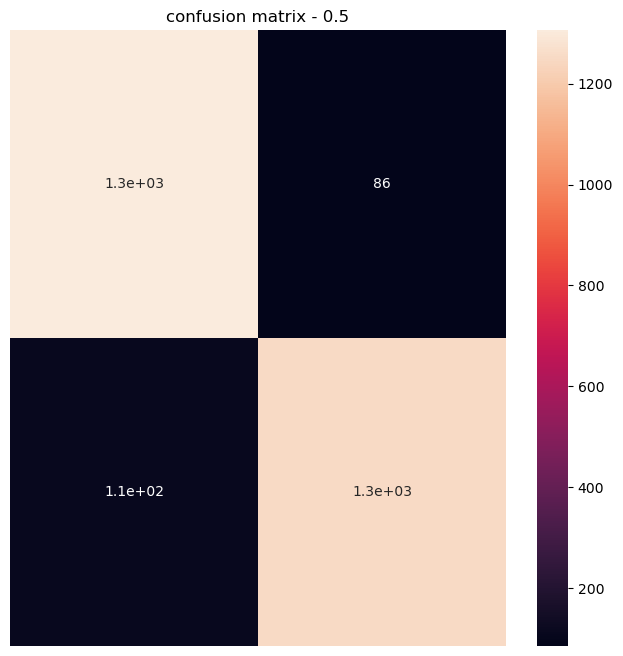

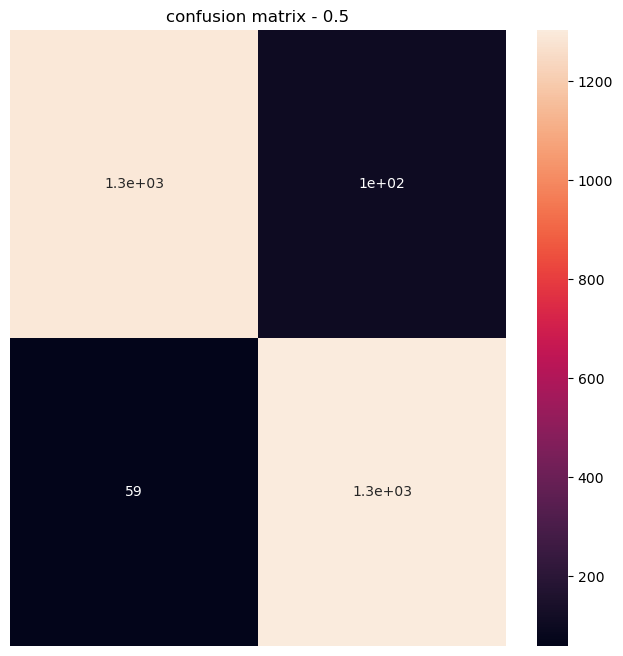

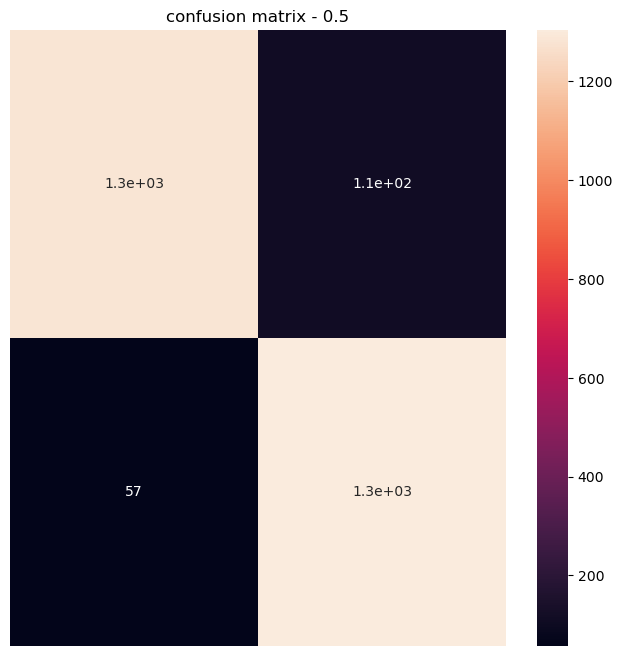

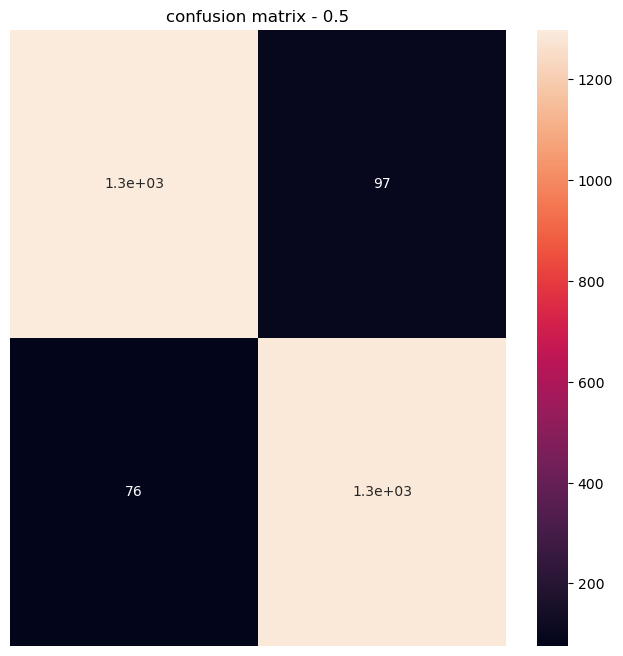

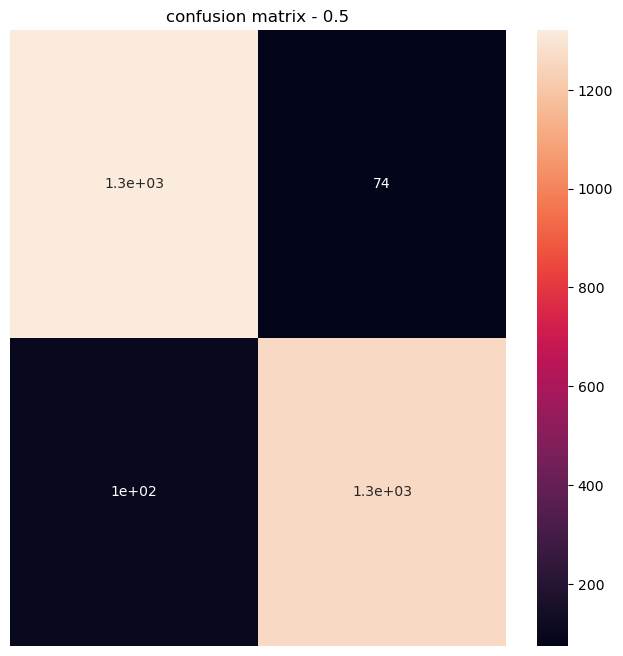

In [625]:
history = lenet_model.fit(train_dataset, 
                          validation_data = val_dataset, 
                          epochs = CONFIGURATION['N_EPOCHS'],
                          verbose = 1,
                          callbacks=[LogImagesCallbackWanDB(), tensorboard_callback])

In [12]:
wandb.finish()

###  Visualization

In [356]:
!rm -rf ./logs/

In [354]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [642]:
tensorboard --logdir='./logs'

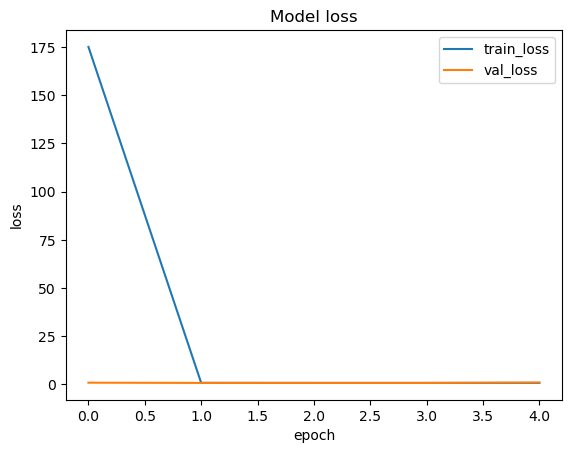

In [254]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

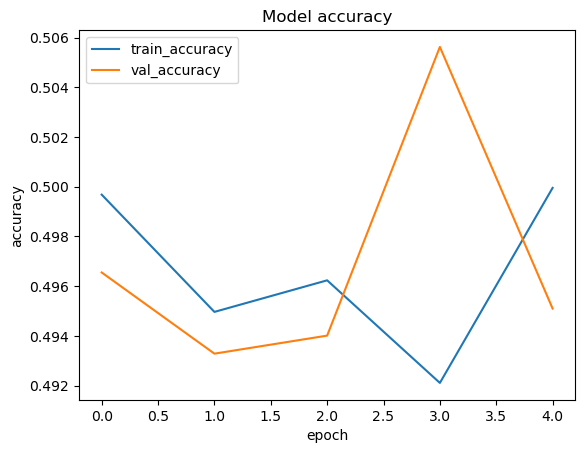

In [255]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### Model Evaluation and Testing

In [218]:
test_dataset = test_dataset.batch(1)

In [219]:
lenet_custom_model.evaluate(test_dataset)

2757/2757 [==============================] - 8s 2ms/step - loss: 0.4468 - tp: 1345.0000 - fp: 291.0000 - tn: 1104.0000 - fn: 17.0000 - accuracy: 0.8883 - precision: 0.8221 - recall: 0.9875 - auc: 0.9492


[0.44678226113319397,
 1345.0,
 291.0,
 1104.0,
 17.0,
 0.8882843852043152,
 0.8221271634101868,
 0.9875183701515198,
 0.9492313265800476]

In [222]:
def parasite_or_not(x):
    if(x < 0.5):
        return str('P')
    else:
        return str('U')

In [223]:
parasite_or_not(lenet_model.predict(test_dataset.take(1)))

1/1 [==============================] - 1s 1s/step


'P'

1/1 [==============================] - 0s 9ms/step


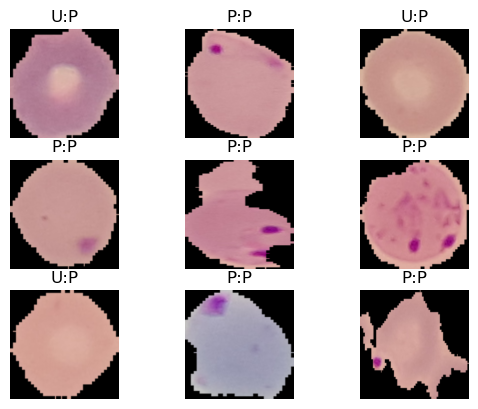

In [224]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))
    
    plt.axis('off')

### Visualizing Confusion Matrix

In [235]:
labels = []

inp = []

for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

In [238]:
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [233]:
# print(labels)
labels = np.array([i[0] for i in labels])


In [234]:
print(labels)

[1 1 0 ... 0 1 1]


In [240]:
predicted = lenet_custom_model.predict(np.array(inp)[:,0,...])
print(predicted[:,0])

87/87 [==============================] - 3s 27ms/step
[0.997726   0.00350764 0.99771506 ... 0.994579   0.98072207 0.99475837]


[[1103  289]
 [  17 1348]]


Text(0.5, 58.7222222222222, 'Predicted')

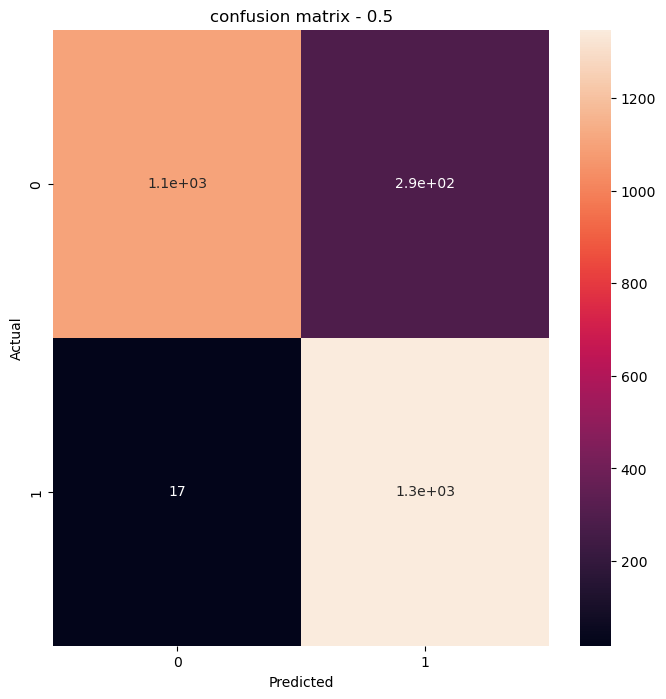

In [245]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)

print(cm)

plt.figure(figsize = (8,8))

sns.heatmap(cm, annot = True,)

plt.title('confusion matrix - {}'.format(threshold))

plt.ylabel('Actual')
plt.xlabel('Predicted')

### ROC Plot

422 422 422


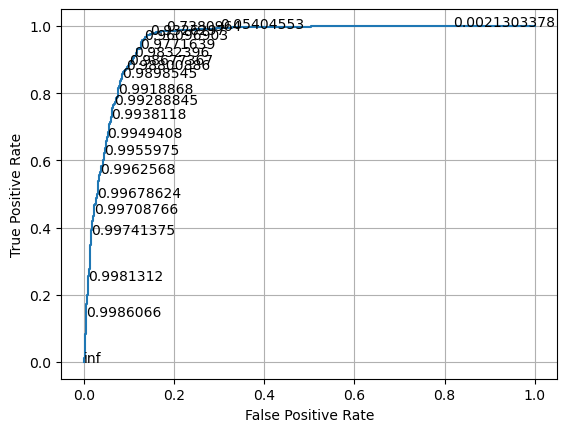

In [249]:
fp, tp, threshold = roc_curve(labels, predicted)
print(len(fp), len(tp), len(threshold))

plt.plot(fp,tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.grid()

skip = 20

for i in range(0, len(threshold), skip):
    plt.text(fp[i],tp[i], threshold[i])

plt.show()